# Dissecting Spotify Valence

The aim of this assignment is to analyse Spotify's Valence metric.
The datasets utilized have been collected from "Music Recommendation System using Spotify Dataset", the "data.csv" file and can be accessed at [kaggle](https://www.kaggle.com/code/vatsalmavani/music-recommendation-system-using-spotify-dataset/input) and "MGD: Music Genre Dataset", the "hit_songs.zip" file and can be accessed at [zenodo](https://zenodo.org/records/4778563).
<br/>


Spotify has a metric known as "valence" to measure the happiness of a track. Interestingly, this metric was not invented by Spotify itself, but came from Echo Nest, a company acquired by Spotify in 2014. Despite its widespread use, the exact methodology behind the valence calculation remains unclear.
<br/>

In the initial phase of this assignment, our goal is to ascertain the characteristics of the song that influence valence, using methods of inferential statistics.

The next step in this project involves the prediction of valence based on the characteristics of the tracks through the application of machine learning techniques. After identifying the optimal technique, we will proceed to evaluate this prediction using a provided test data set.

---

> Mesolora Stamatoula Gerasimoula, Registration number: f2822308 <br />
> MSc Business Analytics  <br />
> Athens University of Economics and Business <br />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Reading the two mention datasets "spotify_hits_dataset_complete.csv" and "data.csv", we take a look at their shape and columns.

In [2]:
spotify_hits_dataset_complete = pd.read_csv('spotify_hits_dataset_complete.csv', delimiter='\t', parse_dates=['release_date'])
data = pd.read_csv('data.csv')
print('data:', data.shape)
print('spotify_hits_dataset_complete:', spotify_hits_dataset_complete.shape)
print('data, columns:', data.columns)
print('spotify_hits_dataset_complete, columns:', spotify_hits_dataset_complete.columns)

data: (170653, 19)
spotify_hits_dataset_complete: (13880, 24)
data, columns: Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')
spotify_hits_dataset_complete, columns: Index(['song_id', 'song_name', 'artist_id', 'artist_name', 'popularity',
       'explicit', 'song_type', 'track_number', 'num_artists',
       'num_available_markets', 'release_date', 'duration_ms', 'key', 'mode',
       'time_signature', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'tempo'],
      dtype='object')


We are interested in columns:

- acousticness
- danceability
- duration_ms
- energy
- id
- instrumentalness
- key
- liveness
- loudness
- mode
- speechiness
- tempo
- time_signature
- valence

which are the songs features according to Web API Reference of Spotify.

We can also keep these for further purposes of the analysis:
- artists
- name
- popularity

In [3]:
data.drop(['release_date','explicit','year'],
          axis=1, inplace=True)

spotify_hits_dataset_complete.drop(['artist_id',
                                    'explicit',
                                    'song_type',
                                    'track_number',
                                    'num_artists',
                                    'num_available_markets',
                                    'release_date'],
                                   axis=1, inplace=True)
data.rename(columns={'id': 'song_id', 'name': 'song_name', 'artists': 'artist_name', 'year': 'release_date'}, inplace=True)

print('data, columns:', data.columns)
print('spotify_hits_dataset_complete, columns:', spotify_hits_dataset_complete.columns)

data, columns: Index(['valence', 'acousticness', 'artist_name', 'danceability', 'duration_ms',
       'energy', 'song_id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'song_name', 'popularity', 'speechiness', 'tempo'],
      dtype='object')
spotify_hits_dataset_complete, columns: Index(['song_id', 'song_name', 'artist_name', 'popularity', 'duration_ms',
       'key', 'mode', 'time_signature', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'valence', 'tempo'],
      dtype='object')


It is time now to concatenate the two DataFrames to one named "all_data".

In [4]:
all_data = pd.concat([spotify_hits_dataset_complete, data], ignore_index=True)
all_data.head(5)

,song_id,song_name,artist_name,popularity,duration_ms,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,16GAMmkIzTIT7aH19TtW3f,Show You,['CXLOE'],45,191235,6,0,4.0,0.00560,0.636,0.693,0.000604,0.1140,-6.014,0.0647,0.388,96.090
1,0MET90crciVlxlE07ub7Rn,Good Love (feat. Tory Lanez),"['Nafe Smallz', 'Tory Lanez']",58,192000,8,0,3.0,0.02090,0.614,0.641,0.000000,0.0659,-6.751,0.2880,0.492,123.539
2,7BpYWzZwrsljT1eIjb0TqR,Told You So,['Paramore'],61,188946,2,0,4.0,0.00290,0.639,0.814,0.000030,0.0529,-5.632,0.0385,0.904,123.922
3,2GrYIUrAYK5TZhSh0RJV6H,Fantastic Boy,['BIGBANG'],0,232586,11,0,4.0,0.00231,0.725,0.836,0.000000,0.0927,-3.927,0.0571,0.544,130.053
4,7G7P0AOE4mXWvdSSroLfZA,Told You,['Krept & Konan'],0,152213,8,1,4.0,0.08830,0.854,0.552,0.000019,0.1510,-7.065,0.0419,0.102,127.966


Getting feature "Time Signature" from Spotify. 

* For storing our credentials, we'll create a file `spotify_config.py` with the following contents:

  ```
  config = {
      'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
      'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
  }
  ```
  
* Then we can create a Spotify client.

* We will get, for each of the tracks of file data.csv, theri Time Signature, which belongs to the [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features) that we do not have.

* To do that, we'll create a dictionary keyed by `song_id`, with values being the audio features for the specific track.

In [5]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

features = {}
all_track_ids = list(data['song_id'].unique())

Given that the API call for fetching audio features permits retrieving a maximum of 100 tracks at once, we need to iterate through batches. In this scenario, we'll iterate using batches of 50 track IDs, implementing a 2-second time window between each iteration to ensure compliance with Spotify's rate limits.
<br\>

We'll store the retrieved features in a CSV file named 'spotify_features'. This way, we can easily access them later without having to request them from Spotify again.
Below is the related code:

- import time
- start = 0 num_tracks = 50 features = {}

- while start < len(all_track_ids): print(f'getting from {start} to {start+num_tracks}') tracks_batch =   all_track_ids[start:start+num_tracks] features_batch = sp.audio_features(tracks_batch) for track_id, track_features in zip(tracks_batch, features_batch): features[track_id] = {'time_signature': track_features['time_signature']} start += num_tracks time.sleep(2)

- features_df = pd.DataFrame.from_dict(features, orient='index') features_df.to_csv('spotify_features.csv')
<br\>

We read the "spotify_features.csv" file and name the fisrt column "song_id".

In [6]:
features = pd.read_csv('spotify_features.csv')
features.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)
songs = pd.merge(data, features, on='song_id', suffixes=('_x', '_y'))
print(songs.shape)
print(songs.isna().sum())
songs.head(5)

(170653, 17)
valence             0
acousticness        0
artist_name         0
danceability        0
duration_ms         0
energy              0
song_id             0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
song_name           0
popularity          0
speechiness         0
tempo               0
time_signature      0
dtype: int64


,valence,acousticness,artist_name,danceability,duration_ms,energy,song_id,instrumentalness,key,liveness,loudness,mode,song_name,popularity,speechiness,tempo,time_signature
0,0.0594,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,0.0366,80.954,4
1,0.9630,0.732,['Dennis Day'],0.819,180533,0.341,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,0.4150,60.936,4
2,0.0394,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,0.0339,110.339,4
3,0.1650,0.967,['Frank Parker'],0.275,210000,0.309,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,0.0354,100.109,3
4,0.2530,0.957,['Phil Regan'],0.418,166693,0.193,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,0.0380,101.665,4


features = pd.read_csv('spotify_features.csv')
features.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)

songs = pd.merge(data, features, on='song_id', suffixes=('_x', '_y'))
songs['time_signature_x'].fillna(songs['time_signature_y'], inplace=True)
songs.drop('time_signature_y', axis=1, inplace=True)
songs.rename(columns={'time_signature_x': 'time_signature'}, inplace=True)
print(songs.shape)
print(songs.isna().sum())
songs.head(5)

Upon examination of the effect of dancing on valence, it becomes apparent that there is a positive relationship between these two variables. As dancability increases, valence tends to increase too. FAlthoough, when the dancability index of a track approaches 1 (>0,9), valence tends to exhibit extreme values, either very high or very low.

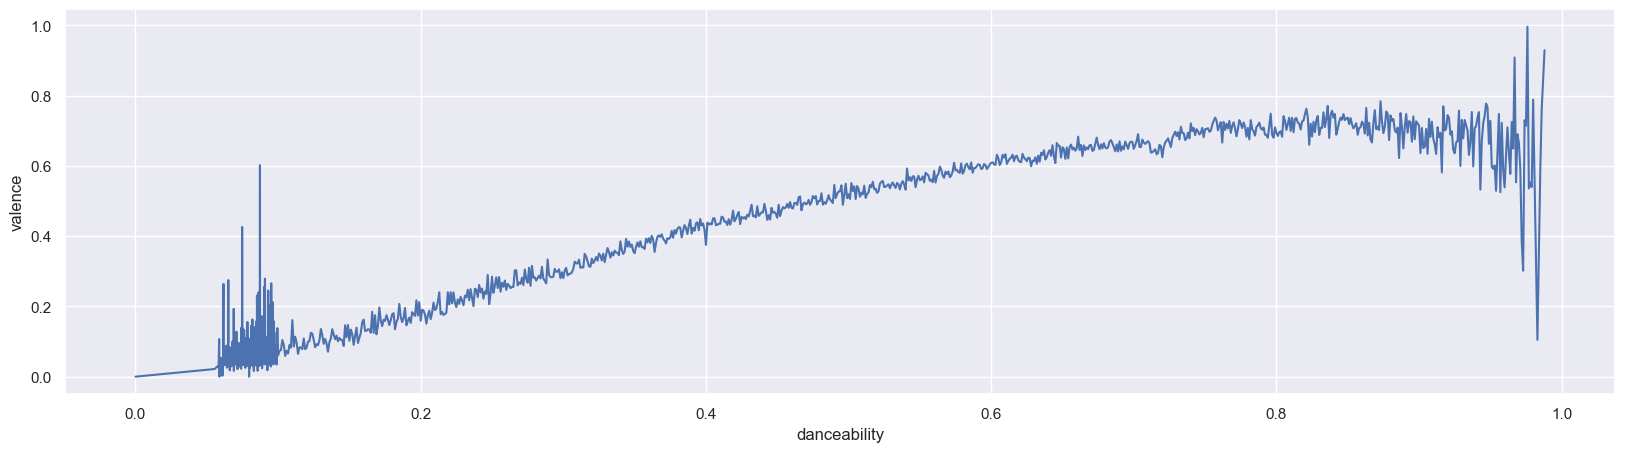

In [7]:
dance_valence = songs.groupby('danceability')['valence'].mean()
sns.set_theme()
plt.figure(figsize=(20,5))
_ = sns.lineplot(x=dance_valence.index, y=dance_valence)

On the whole, songs are mostly on the middle of the scale.

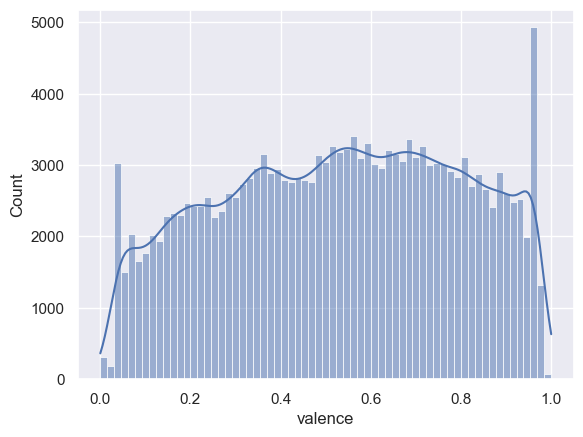

In [8]:
_=sns.histplot(x='valence', data=songs, kde=True)

Let's take a look at the distribution of the features.
- Danceability is the only feature close to normal distribution 

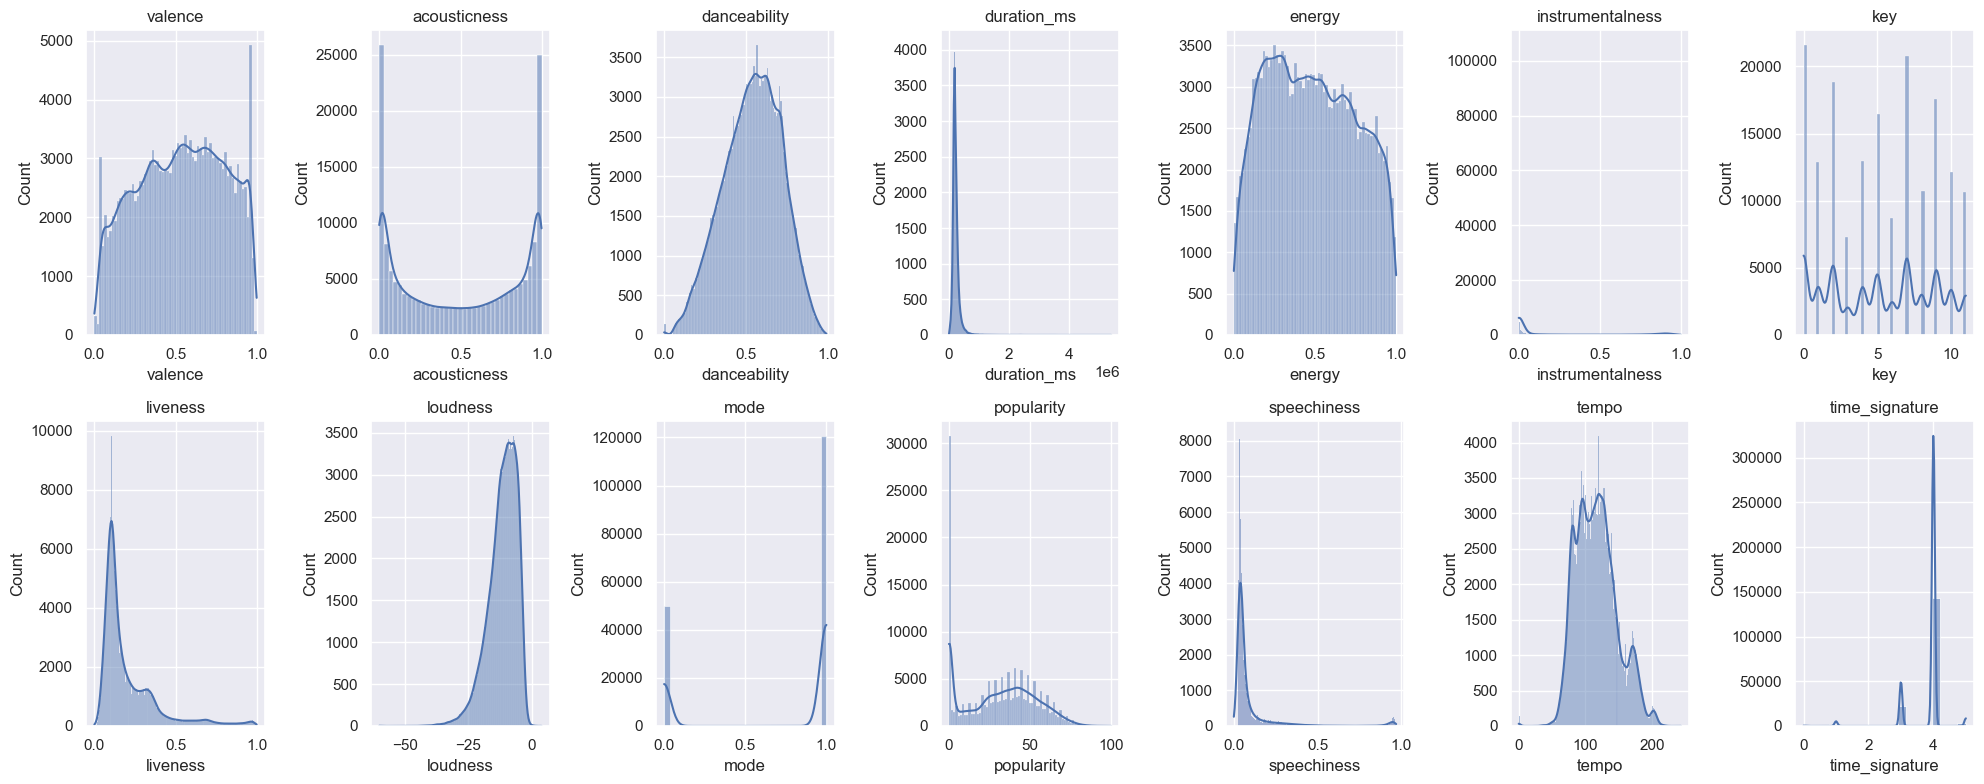

In [111]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(2, 7, figsize=(20, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes = axes.flatten()

numeric_columns = [column for column in songs.columns if songs[column].dtype != object]

num_columns = min(len(numeric_columns), len(axes))

for i, column in enumerate(numeric_columns[:num_columns]):
    sns.histplot(x=column, data=songs, kde=True, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

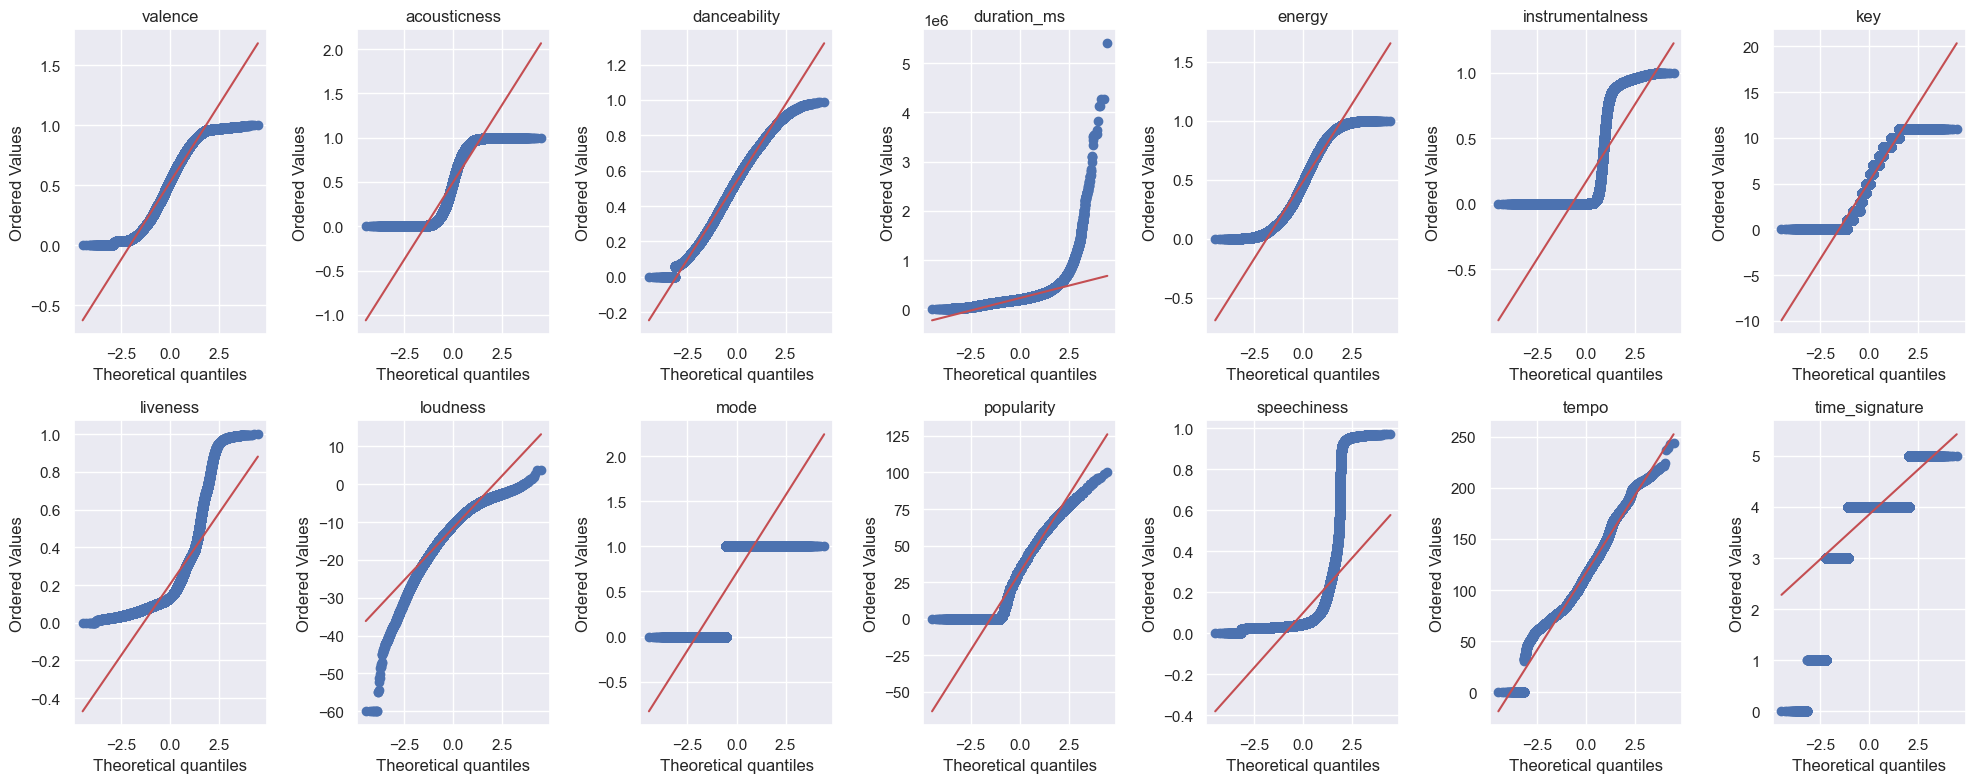

In [108]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(2, 7, figsize=(20, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes = axes.flatten()

numeric_columns = [column for column in songs.columns if songs[column].dtype != object]

num_columns = min(len(numeric_columns), len(axes))

for i, column in enumerate(numeric_columns[:num_columns]):
    stats.probplot(songs[column], dist="norm", plot=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

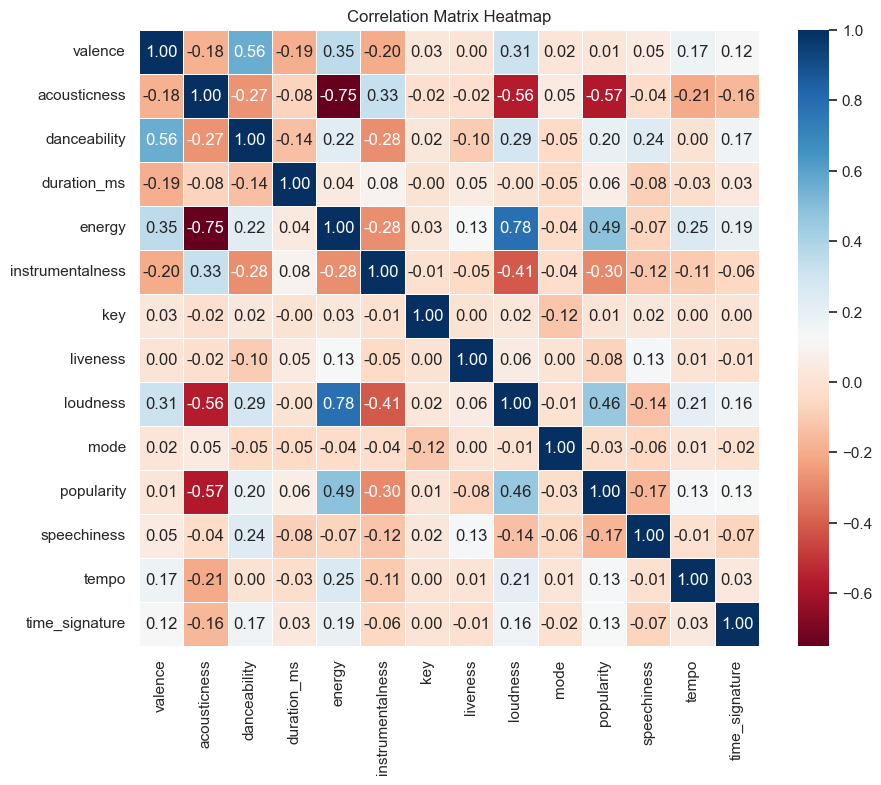

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_variables = songs.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_variables.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Acousticness and Energy are highly (negative) correlated (ρ=-0,75) <br />
Loundness and Energy are highly (positive) correlated (ρ=0,78)

In [276]:
from statsmodels.tools.tools import add_constant

X = songs[['popularity', 'duration_ms', 'key', 'mode', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo']]
Y = songs['valence']

In [176]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for i, colname in enumerate(X.columns[1:], 1):
    vif = variance_inflation_factor(X, i)
    print(f'VIF for {colname} = {vif:.2f}')

VIF for duration_ms = 4.28
VIF for key = 3.17
VIF for mode = 3.37
VIF for acousticness = 5.34
VIF for danceability = 10.33
VIF for energy = 10.02
VIF for instrumentalness = 1.73
VIF for loudness = 9.35
VIF for speechiness = 1.68
VIF for tempo = 14.24


In [184]:
songs[['danceability', 'energy', 'tempo', 'loudness']].corr()

,danceability,energy,tempo,loudness
danceability,1.000000,0.221967,0.001801,0.285057
energy,0.221967,1.000000,0.250865,0.782362
tempo,0.001801,0.250865,1.000000,0.209774
loudness,0.285057,0.782362,0.209774,1.000000


* According to the combination of high VIF values and moderate to high correlation coefficients between 'danceability' and 'energy', we can say that these variables are highly correlated and may exhibit multicollinearity.

Let's build a linear regression using ordinary least squares to model the data

In [185]:
full_model = smf.ols(formula="valence ~ popularity + duration_ms + key + mode + time_signature + danceability + energy + instrumentalness + liveness + speechiness + tempo", data=songs)
full_model_res = full_model.fit()
full_model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 1.346e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:12:27   Log-Likelihood:                 38965.
No. Observations:              170653   AIC:                        -7.791e+04
Df Residuals:                  170641   BIC:                        -7.779e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0160      0.004     -3.579      0.000      -0.025      -0.007
popularity          -0.0035   2.58e-05   -137.044      0.000      -0.004      -0.003
duration_ms        -2.4e-07   3.78e-09    -63.524      0.000   -2.47e-07   -2.33e-07
key                  0.0010      0.000      7.588      0.000       0.001       0.001
mode                 0.0186      0.001     17.883      0.000       0.017       0.021
time_signature      -0.0018      0.001     -1.886      0.059      -0.004    6.97e-05
danceability         0.8240      0.003    275.166      0.000       0.818       0.830
energy               0.3259      0.002    151.668      0.000       0.322       0.330
instrumentalness    -0.0251      0.002    -15.283      0.000      -0.028      -0.022
liveness             0.0217      0.003      7.776      0.000       0.016       0.027
speechiness         -0.1992      0.003    -63.955      0.000      -0.205      -0.193
tempo                0.0010   1.58e-05     64.567      0.000       0.001       0.001
==============================================================================
Omnibus:                      964.264   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.137
Skew:                          -0.183   Prob(JB):                    8.89e-214
Kurtosis:                       3.059   Cond. No.                     2.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Time_signature is not significant at the 5% level (p = 0.059)
<br/>

After removing this variable and creating model2, the results still have not improved.

In [186]:
model2 = smf.ols(formula="valence ~ popularity + duration_ms + key + mode + danceability + energy + instrumentalness + liveness + speechiness + tempo", data=songs)
model2_res = model2.fit()
model2_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                 1.480e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:13:45   Log-Likelihood:                 38963.
No. Observations:              170653   AIC:                        -7.790e+04
Df Residuals:                  170642   BIC:                        -7.779e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0221      0.003     -7.264      0.000      -0.028      -0.016
popularity          -0.0035   2.58e-05   -137.064      0.000      -0.004      -0.003
duration_ms      -2.403e-07   3.78e-09    -63.644      0.000   -2.48e-07   -2.33e-07
key                  0.0010      0.000      7.593      0.000       0.001       0.001
mode                 0.0186      0.001     17.893      0.000       0.017       0.021
danceability         0.8231      0.003    277.892      0.000       0.817       0.829
energy               0.3253      0.002    152.643      0.000       0.321       0.330
instrumentalness    -0.0252      0.002    -15.313      0.000      -0.028      -0.022
liveness             0.0217      0.003      7.782      0.000       0.016       0.027
speechiness         -0.1987      0.003    -64.026      0.000      -0.205      -0.193
tempo                0.0010   1.58e-05     64.577      0.000       0.001       0.001
==============================================================================
Omnibus:                      961.080   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              977.858
Skew:                          -0.183   Prob(JB):                    4.58e-213
Kurtosis:                       3.059   Cond. No.                     2.24e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We are going to use Stepwise comparison, with direction set to "both", in order to find out which variables we should keep in order to achieve a smaller AIC. Althoough, we will exclude variable "energy" to avoid multicollinearity issues.
- We see that danceability and tempo are enough in order to describe valence.

In [279]:
import statsmodels.api as sm

selected_predictors = []
selected_aic = []

max_iterations = len(X.columns)

direction = 'both'

exclude_variable = 'energy'

for i in range(max_iterations):
    if direction in ['forward', 'both']:
        best_aic = float('inf')
        best_predictor = None
        for predictor in X.columns:
            if predictor != exclude_variable and predictor not in selected_predictors:
                predictors_subset = selected_predictors + [predictor]
                X_subset = sm.add_constant(X[predictors_subset])
                model = sm.OLS(Y, X_subset)  # Use OLS regression
                result = model.fit()
                aic = result.aic
                if aic < best_aic:
                    best_aic = aic
                    best_predictor = predictor
        if best_predictor is not None:
            selected_predictors.append(best_predictor)
            selected_aic.append(best_aic)
            print(f'Added predictor: {best_predictor}, AIC: {best_aic}')
    
    if direction in ['backward', 'both']:
        if len(selected_predictors) > 0:
            worst_p_value = 0
            worst_predictor = None
            for predictor in selected_predictors:
                if predictor != exclude_variable:
                    predictors_subset = [pred for pred in selected_predictors if pred != predictor]
                    X_subset = sm.add_constant(X[predictors_subset])
                    model = sm.OLS(Y, X_subset)  # Use OLS regression
                    result = model.fit()
                    p_values = result.pvalues
                    max_p_value = p_values.max()
                    if max_p_value > worst_p_value:
                        worst_p_value = max_p_value
                        worst_predictor = predictor
            if worst_predictor is not None:
                selected_predictors.remove(worst_predictor)
                print(f'Removed predictor: {worst_predictor}, Worst p-value: {worst_p_value}')

min_aic_index = selected_aic.index(min(selected_aic))
best_predictors = selected_predictors[:min_aic_index + 1]
print("Predictors with the smallest AIC:", best_predictors)


Added predictor: danceability, AIC: -35254.03424184397
Added predictor: tempo, AIC: -42640.193123779376
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: loudness, Worst p-value: 1.0831169943874588e-272
Added predictor: loudness, AIC: -46846.6037809439
Removed predictor: l

Although, in order to aviheve a higher R-squared, we can add some more variables to the new model "model3".
<br/>

R-squared is a little less than before but the difference is minimal (0.42) and we achieved that with a very simpler model.
<br/>

**sqrt(valence) = 0.1960 + 0.6725 * danceability + 0.0012 * tempo + ε**
- When all predictors are zero, the predicted square root of 'valence' is approximately 0.1960.
-  For every one unit increase in 'danceability', the predicted square root of 'valence' increases by approximately 0.6725, holding all other variables constant.
- For every one unit increase in 'tempo', the predicted square root of 'valence' increases by approximately 0.0012, holding all other variables constant.
- ε ~ Ν(0, 0.2738^2)

In [333]:
# Fit the OLS model with log-transformed 'valence'
songs['sqrt_valence'] = np.sqrt(songs['valence'])

model3 = smf.ols(formula="sqrt_valence ~ danceability + tempo", data=songs)

model3_res = model3.fit()
model3_res.summary()
y_pred = model3_res.predict()

residuals = songs['valence'] - y_pred
model3_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sqrt_valence   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                 4.915e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:06:54   Log-Likelihood:                 66889.
No. Observations:              170653   AIC:                        -1.338e+05
Df Residuals:                  170650   BIC:                        -1.337e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1960      0.002     99.554      0.000       0.192       0.200
danceability     0.6725      0.002    299.257      0.000       0.668       0.677
tempo            0.0012   1.29e-05     92.978      0.000       0.001       0.001
==============================================================================
Omnibus:                     5621.579   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6190.875
Skew:                          -0.463   Prob(JB):                         0.00
Kurtosis:                       3.120   Cond. No.                         821.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [336]:
rss = np.sum(residuals ** 2)
df_resid = 170650  # As per the summary output
residual_std_error = np.sqrt(rss / df_resid)
print("Residual Standard Error:", residual_std_error)

Residual Standard Error: 0.27387231600036793


Checking the distribution of residues, the results are close to normality, although there are some outliers.

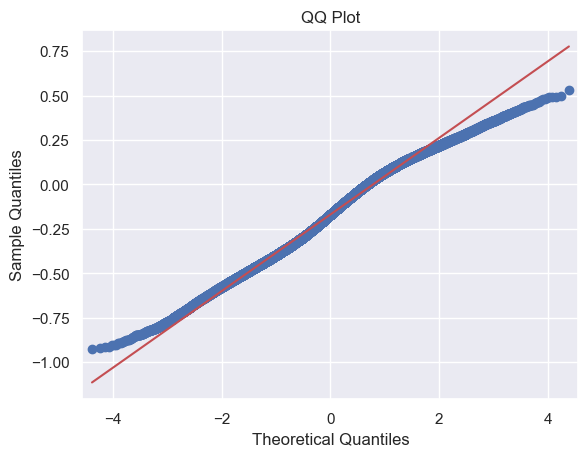

In [337]:
sm.qqplot(residuals, line='s')  
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Predict Valence

In [17]:
import sklearn as sk

#for scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# for learning
from sklearn.model_selection import train_test_split

# for DecisionTree Regressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

## Scaler & Training

We'll split our data to training and test datasets. Our features will be the different columns apart from Valence, which is our target.

Our task involves regression, as we want to predict the value of a numerical target - "Valence".

In [172]:
X = songs[['popularity', 'duration_ms', 'key', 'mode', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'time_signature', 'speechiness', 'tempo']]
Y = songs['valence']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

For the hyperparameters' visualization we set the `feature_cols` and `feature_names` as follows.

In [63]:
column_types = songs.dtypes
feature_cols = [col for col in songs.columns if col != 'valence' and column_types[col] != 'object']

if 'sqrt_valence' in feature_cols:
    feature_cols.remove('sqrt_valence')

feature_names = feature_cols

## DecisionTree Regressor

The best hyperparameters of the DecisionTree Regressor are:
- `max_depth: 15`</br>
The "max_depth" parameter controls the maximum depth of the decision tree. A depth of 15 means that the tree can have up to 15 levels of decisions from the root node to the leaf nodes. A value of 15 suggests that the decision tree model can make decisions based on up to 15 features or combinations of features before reaching a prediction
 </br>
 
- `min_samples_split: 200` </br>
The "min_samples_split" parameter defines the minimum number of samples required to split an internal node in the decision tree. With min_samples_split set to 200, the decision tree algorithm will not split a node if the number of samples at that node is less than 200. This parameter helps control the complexity of the decision tree and prevent overfitting by ensuring that a node is split only when it contains a sufficient number of samples to make the split statistically meaningful.

*Mean Absolute Error: 0.13988058935881326*

In [40]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [10,15,20],
    'min_samples_split': [400,200,100]
}

dt_regressor = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

best_dt_model = grid_search.best_estimator_

y_test_pred = best_dt_model.predict(X_test)

mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error on Testing Set:", mae)

best_dt_model

Mean Absolute Error on Testing Set: 0.13988058935881326


DecisionTreeRegressor(max_depth=15, min_samples_split=200, random_state=42)

One benefit of the Desicion tree regressor is that we can inspect which variables really contribute to the prediction.
<br/>
As we can see in the plot below the variables that are not really helpfull are:
- Popularity
- Mode
- Loudness
- Duration_ms
- Energy
- Speechiness

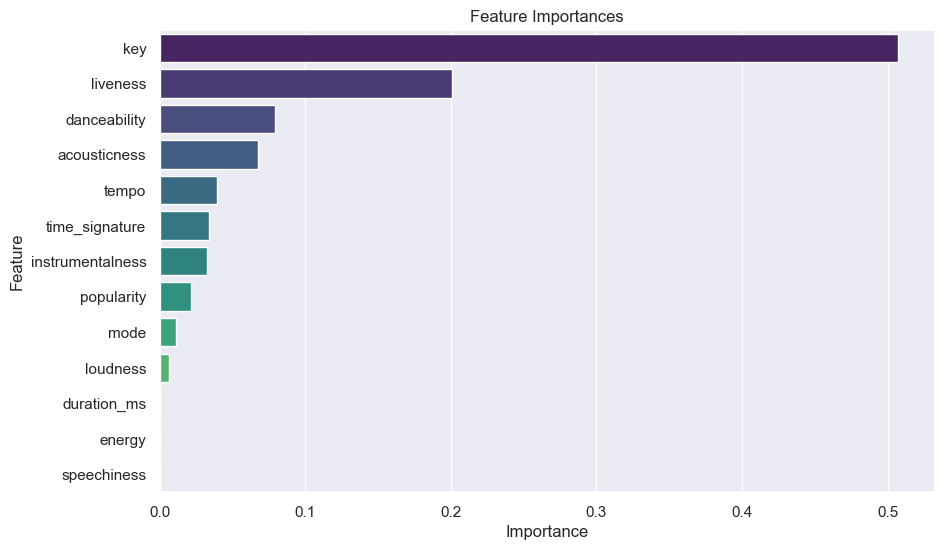

In [42]:
feature_importances = best_dt_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Random Forest

The best hyperparameters of the Random Forest are:
- `n_estimators: 75` </br>
The "n_estimators" hyperparameter determines the number of decision trees to be included in the forest. Each decision tree is trained independently on a random subset of the training data. Setting n_estimators to 75 means that the Random Forest ensemble will consist of 75 decision trees. Each tree is trained on a different bootstrap sample of the training data, meaning that each tree is trained on a subset of the original training dataset created by randomly sampling with replacement.  Increasing the number of trees in the Random Forest generally leads to improved predictive performance, up to a certain point. By combining predictions from multiple trees, the ensemble can better capture complex patterns in the data and reduce overfitting. Increasing n_estimators increases the diversity of the ensemble, leading to more robust predictions that are less sensitive to noise and outliers in the data.
</br>

- `max_depth: 5` </br>
The "max_depth" parameter controls the maximum depth of each decision tree. A depth of 5 means that the tree can have up to 5 levels of decisions from the root node to the leaf nodes. A value of 15 suggests that the decision tree model can make decisions based on up to 5 features or combinations of features before reaching a prediction
</br>

- `min_samples_leaf:3` </br>
The "min_samples_leaf" hyperparameter determines the minimum number of samples required to be in a leaf node. When set to 3, it specifies that a leaf node must contain at least 3 samples.  By specifying this hyperparameter as 3, you ensure that each leaf node must contain at least 3 samples from the training data. This prevents the model from creating leaf nodes with very few samples, which could potentially capture noise in the data. By setting a minimum threshold for the number of samples in leaf nodes, you encourage the model to generalize better to unseen data by preventing it from memorizing the training data too closely.

In [113]:
param_grid = {
    'n_estimators': [75, 50],
    'max_depth': [3, 5],
    'min_samples_leaf': [3, 5],
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_

y_test_pred = best_rf_model.predict(X_test)


mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error on Validation Set:", mae)

best_rf_model

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 75}
Mean Absolute Error on Validation Set: 0.1550529685369304


RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=75,
                      random_state=42)

## K-Nearest Neighbors Regression

The best hyperparameters of the K-nearest neighbors regression are:
- `n_neighbors: 5` </br>
The "n_neighbors" hyperparameter in K-Nearest Neighbors (KNN) regression specifies the number of nearest neighbors to consider when making predictions for a new data point. In essence, when a prediction needs to be made for a new observation, KNN identifies the 5 closest neighbors in the training dataset based on  Euclidean distance. It then averages the target values among these neighbors to predict the target value for the new observation.
</br>

- `weights: distance` </br>
In KNN regression, the "weights" hyperparameter determines the weight assigned to each neighbor when making predictions for a new data point. When weights is set to "distance", as in this case, the algorithm assigns weights to the neighbors based on their distance from the new data point. Specifically, the weight assigned to each neighbor is inversely proportional to its distance from the new data point. After calculating the weights for all neighbors, the algorithm uses these weights to compute a weighted average of the target values among the neighbors to predict the target value for the new data point.
</br>

- `leaf_size: 5` </br>
The "leaf_size" hyperparameter affects the speed of the construction and query, as well as the memory required to store the tree. When performing a KNN search, organizing the data points into a data structure such as a KD-tree or a Ball-tree can significantly speed up the search process. These data structures partition the feature space into smaller regions, allowing for faster search operations by pruning branches that are unlikely to contain the nearest neighbors. The leaf_size parameter specifies the maximum number of data points that can be stored in a leaf node of the tree data structure. When the number of data points in a leaf node exceeds this threshold, the node is split further, leading to a more refined partitioning of the feature space. A larger leaf_size results in a shallower tree with fewer leaf nodes, potentially reducing the memory overhead but may also increase the search time as more data points need to be examined within each leaf node.
</br>

- `n_jobs: -1` </br>
The n_jobs hyperparameter specifies the number of parallel jobs to run for the neighbor search process in the K-nearest neighbors (KNN) algorithm. Setting it to -1 indicates that the algorithm should utilize all available processors on the system for parallel computation.

*Mean Absolute Error: 0.14610919048686635*

In [82]:
from sklearn.neighbors import KNeighborsRegressor

X_array = X.to_numpy()
y_array = Y.to_numpy()

param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'leaf_size': [5, 20, 30],
    'n_jobs': [-1]
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

best_knn

Best Hyperparameters: {'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
Mean Absolute Error: 0.14610919048686635


KNeighborsRegressor(leaf_size=5, n_jobs=-1, weights='distance')

## Neural network model (supervised)

The best hyperparameters of the Neural network model are:
* `hidden_layer_sizes: 100, 50, 25` </br>
    * The first hidden layer contains 100 neurons.
    * The second hidden layer contains 50 neurons.
    * The third hidden layer contains 25 neurons.</br>
Each neuron in a hidden layer performs a simple calculation on the input data it receives and passes the result to the next layer. The number of neurons in a hidden layer determines how much information the layer can handle and how complex the patterns it can learn. With the hidden_layer_sizes hyperparameter, we specify how many neurons we want in each hidden layer of the neural network. The number of neurons in the hidden layers is a crucial hyperparameter in neural network architecture design. It determines the capacity and complexity of the model. Generally, a larger number of neurons can capture more complex patterns in the data, but it also increases the risk of overfitting.
</br>

* `solver: adam` </br>
The "solver" hyperparameter determines how the neural network learns from the data and adjusts its parameters to minimize the error or loss function. Adam stands for Adaptive Moment Estimation and is a popular optimization algorithm for training neural networks. It combines ideas from both momentum optimization and RMSProp (Root Mean Square Propagation) algorithms.
    * Adaptive Learning Rates: Adam dynamically adjusts the learning rate for each parameter based on the average of past gradients. It computes individual adaptive learning rates for each parameter, allowing it to handle sparse gradients and noisy data.
    *  Momentum: Adam incorporates the concept of momentum, which helps accelerate the optimization process by accumulating past gradients and using them to update the parameters.
    * Bias Correction: Adam performs bias correction to correct the bias in the estimates of the first and second moments of the gradients. This correction helps to make the optimization process more stable, especially in the initial iterations.
</br>

- `learning_rate: constant` </br>
The "learning_rate" hyperparameter determines the magnitude of adjustments made to the weights in each iteration of the optimization algorithm. It essentially governs the speed at which the model learns from the training data.  If the learning rate is too high, the optimization process may overshoot the minimum of the loss function, leading to oscillations or divergence in training. On the other hand, if the learning rate is too low, the optimization process may progress very slowly, requiring many iterations to converge to a satisfactory solution.
Constant' learning rate strategy, means that the learning rate remains fixed throughout the entire training process. This implies that during each iteration of the training process, the weights of the neural network are updated by the same fixed amount, determined by the specified constant learning rate. Regardless of the progress made during training or the current state of the optimization process, the learning rate does not change.

*Mean Absolute Error: 0.13159626023338528*

In [78]:
from sklearn.neural_network import MLPRegressor

param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

mlp_regressor = MLPRegressor(random_state=1)

grid_search = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_mlp_regressor = grid_search.best_estimator_

y_pred = best_mlp_regressor.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

best_mlp_regressor

Best Hyperparameters: {'hidden_layer_sizes': (100, 50, 25), 'learning_rate': 'constant', 'solver': 'adam'}
Mean Absolute Error: 0.13159626023338528


MLPRegressor(hidden_layer_sizes=(100, 50, 25), random_state=1)

## AdaBoostRegressor

The best hyperparameters of the AdaBoostRegressor are:
- `learning_rate: 0.001` </br>
The 'learning_rate' hyperparameter regulates the impact of each decision tree on the final boosted model within AdaBoostRegressor. Specifically, it determines the weight attributed to each decision tree's contribution when merged to create the overall ensemble.  </br>
During the training of AdaBoostRegressor, the decision trees are fitted sequentially. At each stage, the model prioritizes samples that were incorrectly predicted by preceding learners. The learning rate parameter determines the significance of each decision tree's predictions within the ensemble. A lower learning rate assigns reduced importance to each decision tree's prediction, whereas a higher rate assigns greater significance.</br>
Moreover, a lower learning rate can mitigate overfitting by reducing the influence of each weak learner. Consequently, it fosters the development of a more conservative ensemble model.
</br>

- `n_estimators: 75` </br>
The "n_estimators" hyperparameter specifies the number of weak learners that will be sequentially trained in the AdaBoost ensemble. Each weak learner is typically a simple model, a decision tree in this case.

*Mean Absolute Error: 0.13180597546923603*

In [81]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    'n_estimators': [75, 50],
    'learning_rate': [0.001, 1.0, 0.5]
}

base_regressor = DecisionTreeRegressor(max_depth=15, min_samples_split=200)

regr = AdaBoostRegressor(estimator=base_regressor, random_state=45)

grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_regr = grid_search.best_estimator_

y_pred = best_regr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on Testing Set (AdaBoostRegressor):", mae)

best_regr

Best Hyperparameters: {'learning_rate': 0.001, 'n_estimators': 75}
Mean Absolute Error on Testing Set (AdaBoostRegressor): 0.13180597546923603


AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=15,
                                                  min_samples_split=200),
                  learning_rate=0.001, n_estimators=75, random_state=45)

## XGBoost

The best hyperparameters of the XGBoost are:
- `booster: gbtree` </br>
Gradient boosting is an ensemble learning method that builds a series of decision trees sequentially. Each tree corrects the errors made by the previous one, which leads to a more accurate prediction. The final prediction of the "gbtree" model is made by aggregating the predictions of all the individual trees in the ensemble. XGBoost typically uses a weighted averaging scheme where each tree's contribution is weighted based on its performance.
</br>

- `eta: 0.1` </br>
The "eta" hyperparameter in XGBoost, also known as the learning rate, controls the step size during the gradient boosting process. It's a crucial parameter that affects the convergence and performance of the XGBoost model. The "eta" parameter represents the learning rate, which is a scalar value between 0 and 1 and scales the contribution of each tree in the ensemble. A lower learning rate makes the model's updates smaller, while a higher learning rate makes the updates larger. The learning rate acts as a form of regularization in XGBoost. A smaller learning rate encourages more conservative updates to the model, which can help prevent overfitting by allowing the model to learn more slowly and carefully.
</br>

- `max_depth: 10` </br>
The "max_depth" hyperparameter in XGBoost represents the maximum depth of each decision tree in the ensemble. Decision trees in XGBoost are binary trees, where each internal node represents a feature test, and each leaf node represents a prediction. The "max_depth" parameter limits the maximum depth of these trees.
</br>

- `subsample: 0.8` </br>
The "subsample" hyperparameter in XGBoost determines the fraction of samples (observations) to be randomly selected and used in building each tree in the ensemble. By subsampling the training data, XGBoost introduces variation into the trees' training process. This variation helps reduce the model's variance, making it less sensitive to noise and outliers in the training data. As a result, the model becomes more robust and better able to generalize to unseen data. By training each tree on a smaller subset of the data, the model may introduce a slight bias in its predictions. However, this bias is usually outweighed by the reduction in variance, leading to improved overall performance.
</br>

- `colsample_bylevel: 0.8` </br>
In XGBoost, the "colsample_bylevel" hyperparameter controls the fraction of features to be randomly sampled at each level of tree construction. When "colsample_bylevel" is set to a value less than 1, a random subset of features is selected at each level of tree building. With colsample_bylevel set to 0.8, 80% of the features are randomly sampled at each level of tree construction. This introduces randomness into the model, preventing individual trees from relying too heavily on any particular set of features. Trees built with fewer features are less complex and less likely to overfit to the training data. 

*Mean Absolute Error: 0.12433571678298097*

In [173]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

param_grid = {
    'booster': ['gbtree', 'dart'],
    'eta': [0.3, 0.1, 0.5],
    'max_depth': [5, 10, 15],
    'subsample': [0.5, 0.8],
    'colsample_bylevel': [0.5, 0.8]
}

xgb_reg = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_

preds = best_xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("Mean Absolute Error:", mae)

best_xgb_model

Best Hyperparameters: {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'eta': 0.1, 'max_depth': 10, 'subsample': 0.8}
Mean Absolute Error: 0.12433571678298097


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

It is now time to proceed to evaluation of the best prediction model, using the provided test data set.
</br>

After extracting the features corresponding to the given IDs from Spotify, we will proceed by importing the file named 'features_test.csv', which contains all ids with their features.

In [85]:
test_ids = pd.read_csv('spotify_ids_holdout.txt', header=None, names=['track_id'])
test_ids.head(5)

,track_id
0,7x9aauaA9cu6tyfpHnqDLo
1,56y1jOTK0XSvJzVv9vHQBK
2,3rUGC1vUpkDG9CZFHMur1t
3,01qFKNWq73UfEslI0GvumE
4,2YSzYUF3jWqb9YP9VXmpjE


* features_test = {}
* all_track_ids_test = list(test_ids['track_id'].unique())

* start = 0
* num_tracks = 100

* while start < len(all_track_ids_test):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids_test[start:start+num_tracks]
    tracks_info_batch = sp.tracks(tracks_batch)
    for track_info in tracks_info_batch['tracks']:
        track_id = track_info['id']
        popularity = track_info['popularity']
        track_features = sp.audio_features(track_id)[0]
        features_test[track_id] = {
            'valence': track_features['valence'],
            'popularity': popularity,
            'duration_ms': track_features['duration_ms'],
            'key': track_features['key'],
            'mode': track_features['mode'],
            'acousticness': track_features['acousticness'],
            'danceability': track_features['danceability'],
            'energy': track_features['energy'],
            'instrumentalness': track_features['instrumentalness'],
            'liveness': track_features['liveness'],
            'loudness': track_features['loudness'],
            'time_signature': track_features['time_signature'],
            'speechiness': track_features['speechiness'],
            'tempo': track_features['tempo']
        }
    start += num_tracks
    time.sleep(1)

* features_test_df = pd.DataFrame.from_dict(features_test, orient='index')
* features_test_df.to_csv('features_test.csv')

In [87]:
features_test = pd.read_csv('features_test.csv')
features_test.rename(columns={'Unnamed: 0': 'song_id'}, inplace=True)
features_test

,song_id,popularity,valence,duration_ms,key,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,time_signature,speechiness,tempo
0,7x9aauaA9cu6tyfpHnqDLo,88,0.8900,185427,11,1,0.31100,0.802,0.832,0.000000,0.0815,-4.107,4,0.0434,124.997
1,56y1jOTK0XSvJzVv9vHQBK,86,0.7260,230480,2,0,0.25500,0.864,0.556,0.000004,0.1120,-7.683,4,0.1940,99.974
2,3rUGC1vUpkDG9CZFHMur1t,99,0.8440,131872,6,0,0.25600,0.750,0.733,0.000000,0.1140,-3.180,1,0.0319,111.018
3,01qFKNWq73UfEslI0GvumE,84,0.8880,201812,1,1,0.03220,0.853,0.824,0.000000,0.0859,-3.287,4,0.1030,108.044
4,2YSzYUF3jWqb9YP9VXmpjE,91,0.1380,260111,8,1,0.04640,0.663,0.670,0.000089,0.2050,-8.399,4,0.2710,136.952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,3fDTzkvrOo5xQIO480Qmsb,65,0.5530,259080,11,0,0.01130,0.538,0.783,0.000000,0.2810,-2.565,4,0.2220,75.388
1012,4Ls53fBNVfaXTROBi6X8Hw,79,0.0385,123891,11,1,0.06510,0.485,0.545,0.005470,0.0642,-7.924,4,0.0336,150.185
1013,5PLqXnvHH7Gh6CcfiUEr7e,17,0.5950,194920,2,0,0.00388,0.600,0.600,0.000000,0.1220,-7.715,3,0.1150,90.435
1014,0hDE81j4N2DPLbEY4tiCDs,46,0.6880,182857,0,1,0.11500,0.750,0.830,0.000000,0.7650,-3.544,4,0.0683,104.937


In [174]:
models = {
    "Desicion Tree": best_dt_model,
    "Random Forest": best_rf_model,
    "K-Nearest Neighbors": best_knn,
    "Neural network": best_mlp_regressor,
    "AdaBoostRegressor": best_regr,
    "XGBoost": best_xgb_model
}

def evaluate_models(models, X_test, y_test):
    mae_scores = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores[model_name] = mae
    return mae_scores

X_test = features_test[['popularity', 'duration_ms', 'key', 'mode', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'time_signature', 'speechiness', 'tempo']]
y_test = features_test['valence']

mae_scores = evaluate_models(models, X_test, y_test)

for model_name, mae in mae_scores.items():
    print(f"MAE for {model_name}: {mae}")

MAE for Desicion Tree: 0.16595692465579065
MAE for Random Forest: 0.18600711823718502
MAE for K-Nearest Neighbors: 0.5096719080742569
MAE for Neural network: 25919.746972876557
MAE for AdaBoostRegressor: 0.15762528290914024
MAE for XGBoost: 0.1443688669573956


X has feature names, but KNeighborsRegressor was fitted without feature names
X has feature names, but MLPRegressor was fitted without feature names


It is indeed proven that the best method is xgbooster, as it gives the lowest MAE, which corresponds to 0.1443688669573956.